In [1]:
import pickle
import pandasql
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import FloatTensor 
from model.irt import IRT

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from preprocess.data_preprocess_irt import question_train_test_preprocess, question_train_preprocess, question_test_preprocess

In [2]:
import sys 
from train_irt import main 
import matplotlib.cm as cm
colors = ["r","g","b","c","m","y"]

def run_model():
    
    with open(".datasets/total_users.pkl", "rb") as f:
        total_users = len(pickle.load(f))
    with open(".datasets/total_problems.pkl", "rb") as f:
        total_problems = len(pickle.load(f))

    learning_rate = [0.1,0.03,0.009,0.0027]
    optimizer = [ "ADAM"]
    max_iterations = 1
    auc_array_hash, loss_means_array_hash = {}, {}
    
    for idx, opt in enumerate(optimizer):
        loss_means_array = []
        auc_array = []
        for i,r in enumerate(learning_rate):
            print("Here is the reuslt of learning rate: ",r)
            for j in range(0,max_iterations):
                main(r, opt)
                with open(".ckpts/irt_loss_means_new_lr={}_opt={}.pkl".format(r, opt), "rb") as f:
                    loss_means = pickle.load(f)
                loss_means_array.insert(i*len(learning_rate)+j,loss_means)
                with open(".ckpts/irt_aucs_new_lr={}_opt={}.pkl".format(r, opt), "rb") as f:
                    auc = pickle.load(f)
                auc_array.insert(i*len(learning_rate)+j,auc)
        loss_means_array = np.array(loss_means_array)
        auc_array = np.array(auc_array)
        auc_array_hash[opt] = auc_array 
        loss_means_array_hash[opt] = loss_means_array
   
    
    for idx, opt in enumerate(optimizer): 

        auc_array = auc_array_hash[opt]
        loss_means_array = loss_means_array_hash[opt]
        
        fig = plt.figure(facecolor=(1,1,1))
        for i,c in zip(range(0,len(learning_rate)),colors):
            auc_temp = auc_array[i*max_iterations:(i+1)*max_iterations]
            
            plt.title("IRT_{}".format(opt))
            plt.xlabel("Epoch")
            plt.ylabel("Test-AUC")
            plt.plot(np.arange(1,auc_temp.shape[1]+1), np.mean(auc_temp, axis = 0), markerfacecolor = c)
            # plt.fill_between(
            #     np.arange(1,auc_temp.shape[1]+1),
            #     np.mean(auc_temp,axis=0) - np.std(auc_temp,axis=0),
            #     np.mean(auc_temp,axis=0) + np.std(auc_temp,axis=0),
            #     alpha = 0.1,
            #     color = c 
            # )
        plt.legend(learning_rate, title="learning_rate for optimizer_{}".format(opt))
        fig.savefig("model_result/IRT/AUC_{}_OPT_{}.png".format(auc_temp[-1][-1], opt), bbox_inches='tight')
        plt.show()   

        fig = plt.figure(facecolor=(1,1,1))
        for i,c in zip(range(0,len(learning_rate)),colors):
            loss_temp = loss_means_array[i*max_iterations:(i+1)*max_iterations]
            
            plt.title("IRT_{}".format(opt))
            plt.xlabel("Epoch")
            plt.ylabel("Test-LOSS")
            plt.plot(np.arange(1,loss_temp.shape[1]+1), np.mean(loss_temp, axis = 0), markerfacecolor = c)
            # plt.fill_between(
            #     np.arange(1,loss_temp.shape[1]+1),
            #     np.mean(loss_temp,axis=0) - np.std(loss_temp,axis=0),
            #     np.mean(loss_temp,axis=0) + np.std(loss_temp,axis=0),
            #     alpha = 0.1,
            #     color = c 
            # )
        plt.legend(learning_rate, title="learning_rate for optimizer_{}".format(opt))
        fig.savefig("model_result/IRT/LOSS_{}_OPT_{}.png".format(loss_temp[-1][-1], opt), bbox_inches='tight')
        plt.show() 

    # save the best state among choices of learning rate 
    default_state = ".ckpts/irt_model_new_aucs={}_lr={}_opt={}.ckpt".format(auc_array_hash["ADAM"][0][-1],learning_rate[0],"ADAM")
    default_auc = auc_array_hash["ADAM"][0][-1]
    for m,n in enumerate(optimizer):
        auc_array = auc_array_hash[n]
        for i in range(1,len(learning_rate)): 
            if auc_array[i][-1] > default_auc: 
                default_auc = auc_array[i][-1]
                default_state = ".ckpts/irt_model_new_aucs={}_lr={}_opt={}.ckpt".format(default_auc,learning_rate[i],n)
                with open('best_state/best_state.txt','a') as f:
                    # print("save_kc_idx.keys():", save_kc_idx.keys())
                    f.write("")
                    f.write('\n')
                    f.write(default_state)
                    f.write('\n')
    return default_state 

   

In [25]:
import matplotlib.pyplot as plt
from sklearn import utils
import pandasql 
from matplotlib import rc
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

def represent_problem_diff_rate(state):
    print(state)
    # plotting scatter plot of difficulty and average rate 
    with open(".datasets/total_users.pkl", "rb") as f:
        total_users = (pickle.load(f))
    with open(".datasets/total_problems.pkl","rb") as f:
        total_problems = (pickle.load(f))
    # load the state of the model
    device = torch.device("cpu")
    model = IRT(len(total_users), len(total_problems))
    model.load_state_dict(torch.load(state, map_location = device))
    model.eval()

    w1 = model.state_dict()['w1'].numpy()

    w1_process = [1/(1+np.exp(-x)) for x in w1]
    # w1_process = [np.log(1+np.exp(x)) for x in w1]
    # w1_process = [1/1+np.exp(-(np.log(1+np.exp(x)))) for x in w1]
    
    w2 = model.state_dict()['w2'].numpy()

    w1_rate = pd.read_csv('.datasets/user_rate.csv', sep = '\t')
    student_rate = {}
    for idx, row in w1_rate.iterrows():
        student_rate[row["userSeq"]] = row["rate"]

    st_rate = list(student_rate.values())
    st_label = list(student_rate.keys())

    # get the scatter plot for whole students
    fig = plt.figure(facecolor=(1,1,1))
    fig.set_size_inches(15, 15)
    plt.scatter(st_rate, w1_process)
    plt.title("학생 개념지수(모델 예측) vs 학생 평균 정답률(실제 값)")
    plt.xlabel('avg rates(평균 정답률)')
    plt.ylabel('student strength(개념 지수)')
    for label, x, y in zip(st_label, st_rate, w1_process):
        plt.annotate(label, xy = (x, y))
    plt.show()
    fig.savefig('rate_difficulty_rep/학생개념지수_rate_difficulty.png')

    # get scatter plot for random 3 divided groups
    st_label, st_rate, w1_process = utils.shuffle(st_label, st_rate, w1_process)
    size,track = int(len(st_label)/3),0
    for i in range(0,3):
        st_label_new, st_rate_new, w1_process_new = st_label[track:track+size], st_rate[track:track+size], w1_process[track:track+size]
        fig = plt.figure(facecolor=(1,1,1))
        fig.set_size_inches(15, 15)
        plt.scatter(st_rate_new, w1_process_new)
        plt.title("학생 개념지수(모델 예측) vs 학생 평균 정답률(실제 값)")
        plt.xlabel('avg rates(평균 정답률)')
        plt.ylabel('student strength(개념 지수)')
        # for label, x, y in zip(st_label_new, st_rate_new, w1_process_new):
        #     plt.annotate(label, xy = (x, y))
        plt.show()
        fig.savefig('rate_difficulty_rep/group_{}_학생개념지수_rate_difficulty.png'.format(i))
        track += size


    rate = pd.read_csv(".datasets/question_rate.csv", sep = '\t')
    print(rate)
    problem_rate = {}
    for i in range(0, len(rate)):
        problem_rate[rate.iloc[i]["question_id"]] = rate.iloc[i]["rate"]

    problem_weight = {}
    for i,t in enumerate(total_problems):
        problem_weight[t] = w2[i]
        # problem_weight[t] = 1/(1+ np.exp(-(w2[i] - np.log(1+np.exp(w2[i]))))    )
        # problem_weight[t] = w2[i] - np.log(1+np.exp(w2[i]))
    
    labels = [int(k) for k in problem_rate.keys()]  #hold question_id
    rate = list(problem_rate.values())
    weight = list(problem_weight.values()) 
    
    #------------------------전체 문제 scatter plot before preprocessing ------------------------#
    fig = plt.figure(facecolor=(1,1,1))
    fig.set_size_inches(15, 15)
    plt.scatter(rate, weight)
    print("before processing lenght of rate is ", len(rate))
    plt.xlabel('avg rates(평균 정답률)')
    plt.ylabel('easiness(쉬운 정도, y값이 클 수록 쉬움을 뜻함)')
    plt.title("Total problems before pre-processing")
    plt.show()
    fig.savefig('rate_difficulty_rep/difficulty_rate_before_preprocess.png')

    fig = plt.figure(facecolor=(1,1,1))
    plt.hist(weight, bins= 100)
    plt.title("distribution of difficulty before preprocessing")
    fig.savefig("rate_difficulty_rep/difficulty_distribution_before_preprocess.png")
    plt.show()


     #------------------------전체 문제 scatter plot after preprocessing ------------------------#
    with open(".datasets/problem_solved.pkl", "rb") as f:
        problems_solved = pickle.load(f)
    idx_to_remove = []
    for i,qid in enumerate(labels):
        if problems_solved[qid] < 10:
            # labels.remove(qid)
            idx_to_remove += [i]
    print(len(idx_to_remove))
    
    r, w,l = [r1 for i1, r1 in enumerate(rate) if i1 not in idx_to_remove], \
        [r2 for i2, r2 in enumerate(weight) if i2 not in idx_to_remove], \
            [r3 for i3, r3 in enumerate(labels) if i3 not in idx_to_remove]
    fig = plt.figure(facecolor=(1,1,1))
    fig.set_size_inches(15, 15)
    plt.scatter(r, w)
    print("after processing lenght of rate is ", len(r))
    plt.xlabel('avg rates(평균 정답률)')
    plt.ylabel('easiness(쉬운 정도, y값이 클 수록 쉬움을 뜻함)')
    plt.title("Total problems after pre-processing")
    fig.savefig("rate_difficulty_rep/difficulty_rate_after_preprocess.png")
    plt.show()


    fig = plt.figure(facecolor=(1,1,1))
    plt.hist(w, bins= 100)
    plt.title("distribution of difficulty after preprocessing")
    fig.savefig("rate_difficulty_rep/difficulty_distribution_after_preprocess.png")
    plt.show()
    
    question_difficulty = {}
    for question_id, difficulty in zip(labels, weight):
        question_difficulty[question_id] = difficulty
    with open(".datasets/question_difficulty.pkl", "wb") as f:
        pickle.dump(question_difficulty, f)
    
    question_difficulty_preprocess= {}
    for question_id, difficulty in zip(labels, weight):
        question_difficulty_preprocess[question_id] = difficulty
    with open(".datasets/question_difficulty_preprocess.pkl", "wb") as f:
        pickle.dump(question_difficulty_preprocess, f)


    # # make 중단원 - 문제 
    # dataset_path = ".datasets/experiment.csv"
    # df = pd.read_csv(dataset_path, sep = '\t')
    # df = df.rename(columns={'# username': 'username', ' userSeq': 'userSeq', \
    #  ' question_id': 'question_id', ' isCorrect': 'isCorrect', 'regdate': 'start', \
    #       ' concepts\t\t\t\t\t':'concepts' })
    # df = df.rename(columns={' concepts': 'concepts', ' skills': 'skills', ' conditions': 'conditions', \
    #     ' categories': 'categories', 'category2': 'unit2seqs', 'category3': 'unit3seqs', \
    #         'category4': 'unit4seqs', 'category5': 'unit5seqs'})   
    # unit2seqs = np.unique(df['unit2seqs'].values)
    # unit2seqs_problem = {}
    # for unit2 in unit2seqs:
    #     df_one = df[df["unit2seqs"] == unit2]
    #     problems = np.sort(np.unique(df_one["question_id"].values))
    #     unit2seqs_problem[unit2] = problems 

    # # iterate through 중단원 and plot the scatter plot 
    # for unit2key in unit2seqs_problem.keys():
    #     problems = unit2seqs_problem[unit2key]
    #     labels = np.array(labels)
    #     idx = np.in1d(labels, problems).nonzero()[0]
    #     labels_new = [labels[i] for i in idx]
    #     rate_new = [rate[i] for i in idx]
    #     weight_new = [weight[i] for i in idx]

    #     #draw the scatter plot 
    #     fig = plt.figure(facecolor=(1,1,1))
    #     fig.set_size_inches(15, 15)
    #     plt.scatter(rate_new, weight_new)
    #     plt.xlabel('avg rates(평균 정답률)')
    #     plt.ylabel('easiness(쉬운 정도, y값이 클 수록 쉬움을 뜻함)')
    #     # for label, x, y in zip(labels_new, rate_new, weight_new):
    #     #     plt.annotate(label, xy = (x, y))
    #     plt.title(unit2key+": 문제 난이도(모델 예측) vs 문제 평균 정답률(실제 값)")
    #     plt.show()
    #     fig.savefig('rate_difficulty_rep/{}_rate_difficulty.png'.format(unit2key))
    
    
    
    

# run the whole process here

.ckpts/irt_model_new_aucs=0.7459559837350823_lr=0.0027_opt=ADAM.ckpt


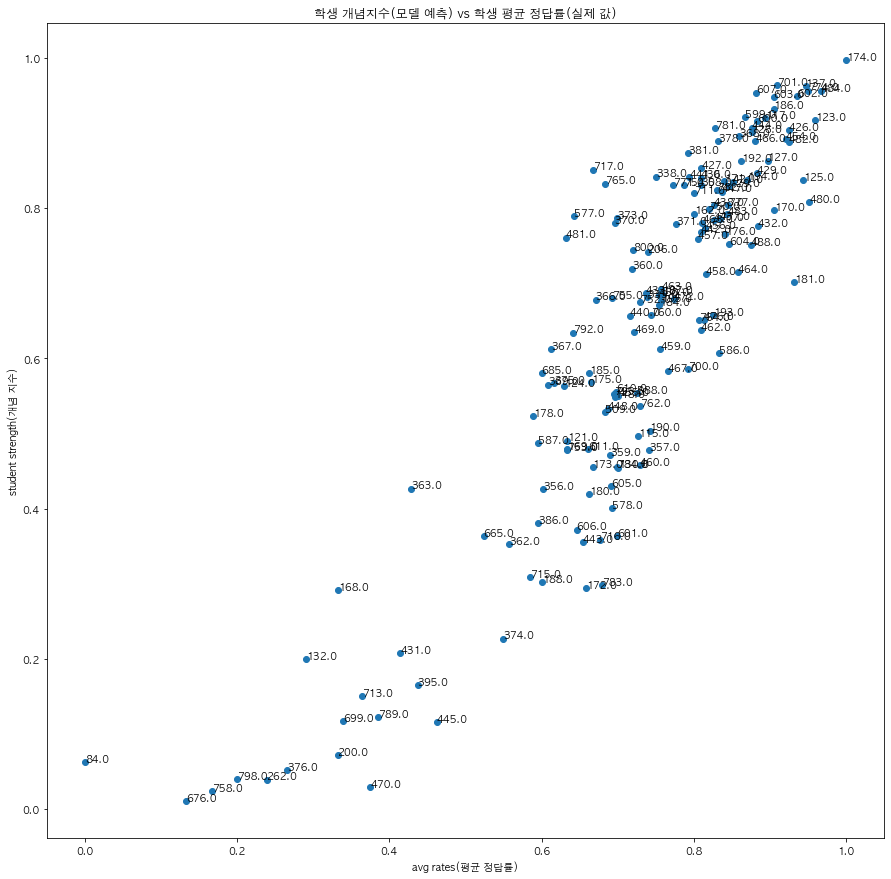

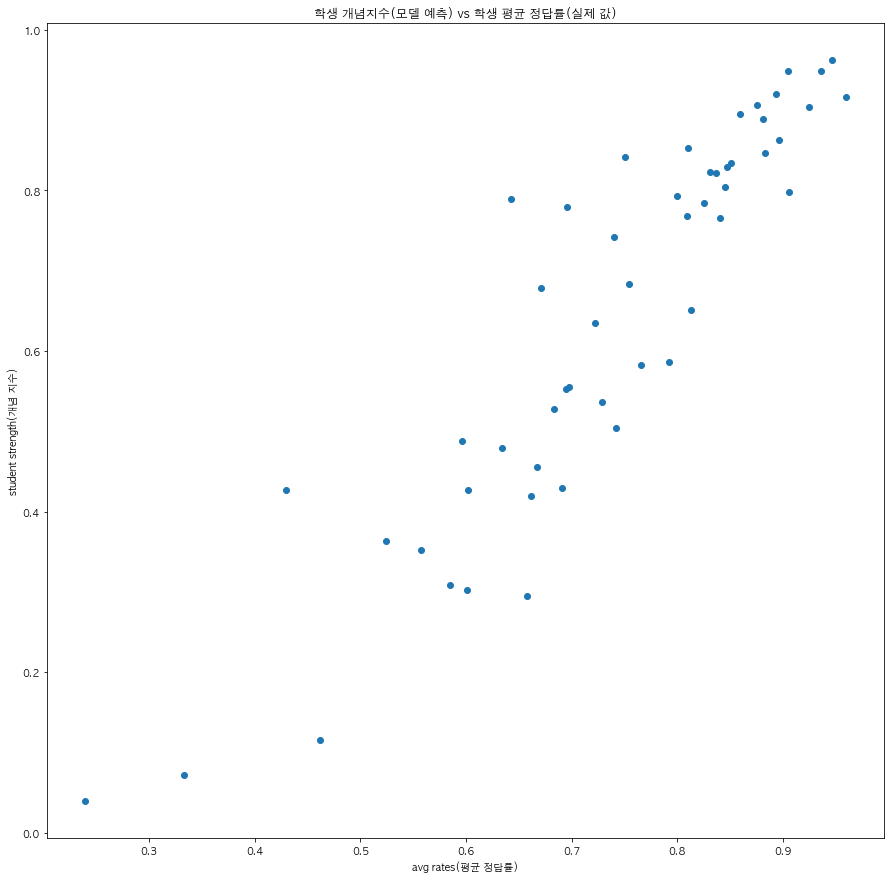

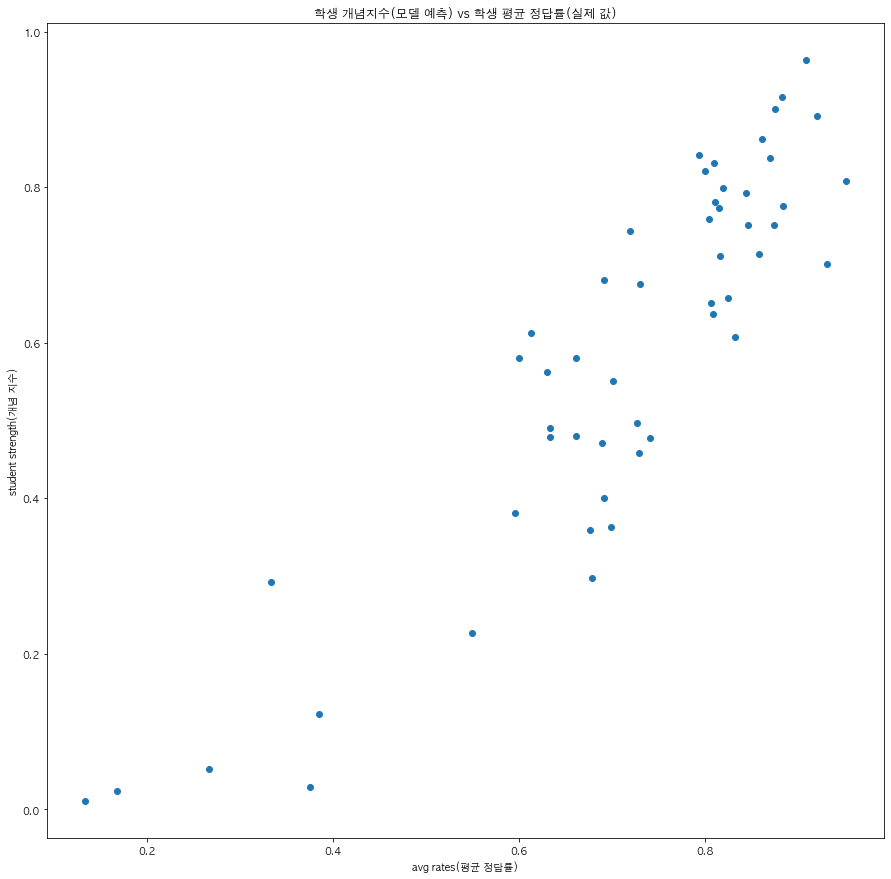

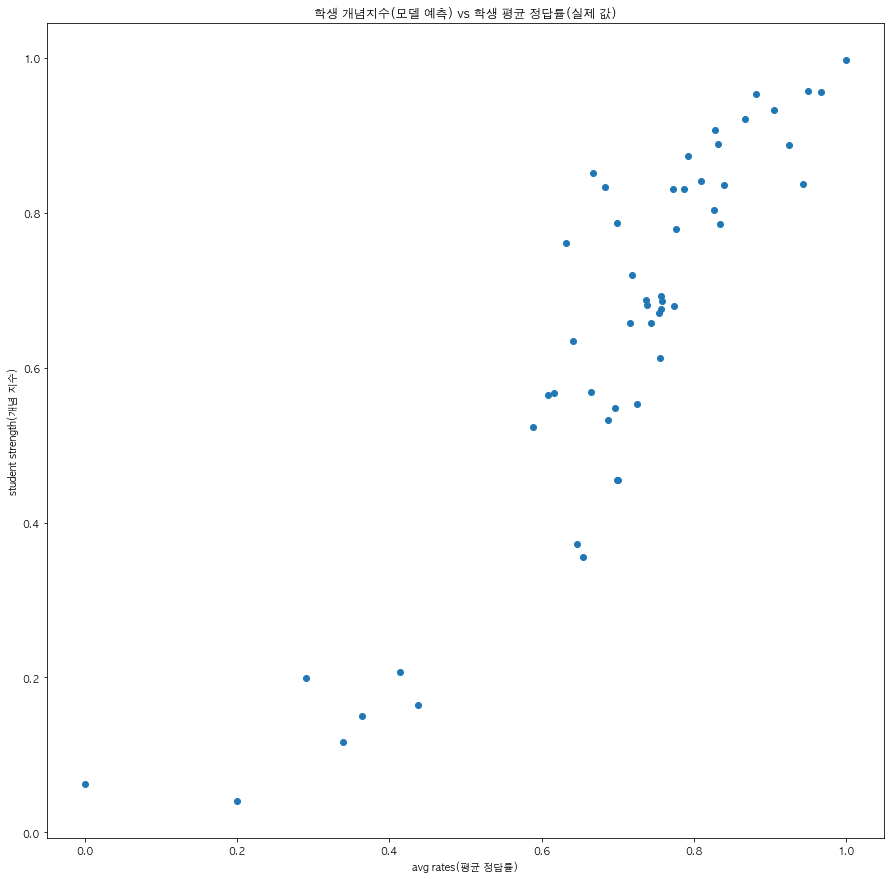

      question_id   rate
0               3  0.818
1              12  0.643
2              14  0.591
3              29  0.778
4              37  0.933
...           ...    ...
5685        15636  1.000
5686        15637  0.000
5687        15638  0.778
5688        15640  1.000
5689        15649  0.750

[5690 rows x 2 columns]
before processing lenght of rate is  5690


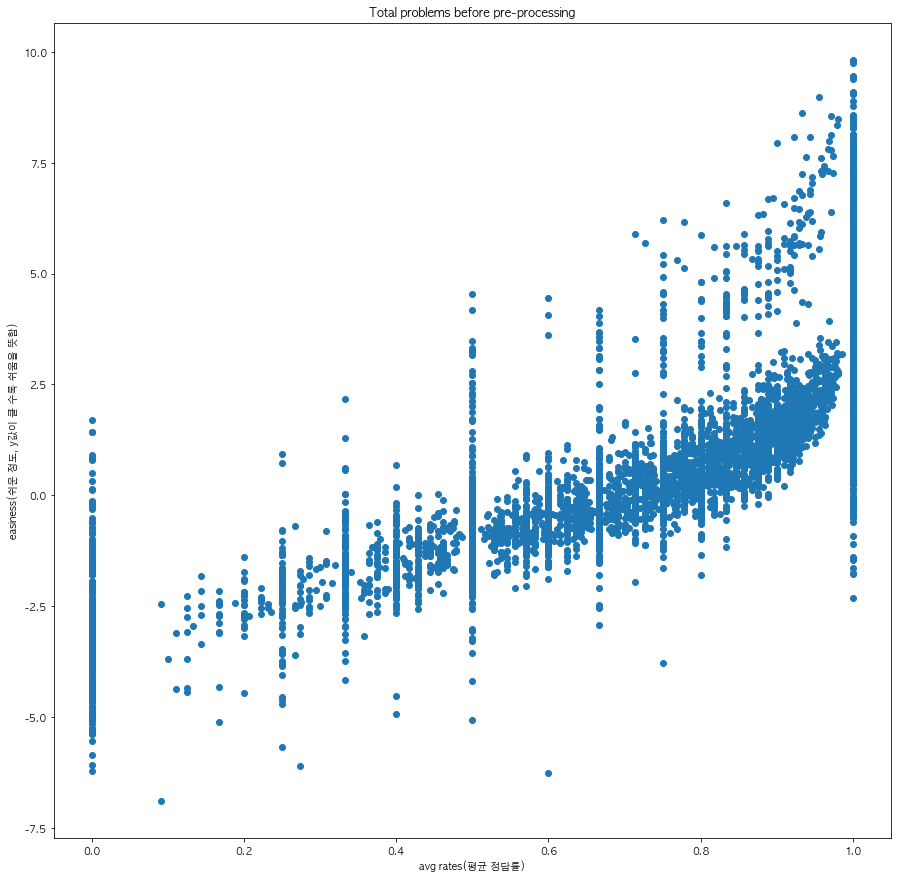

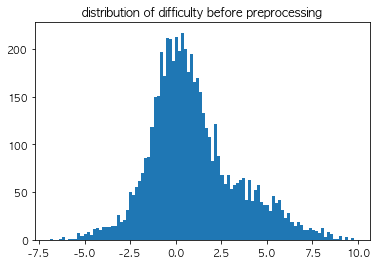

2909
after processing lenght of rate is  2781


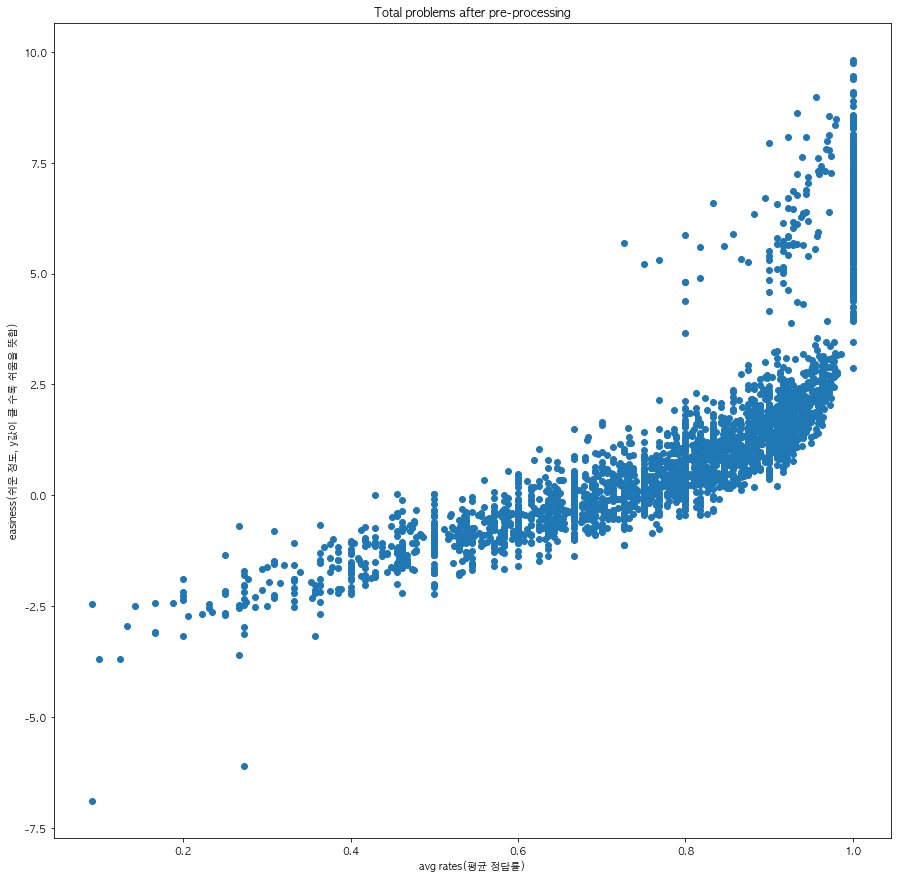

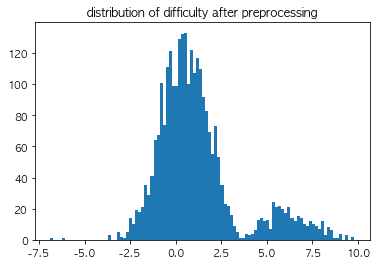

In [26]:
#data preprocess
df_train, df_test, train_user_list, test_user_list = question_train_test_preprocess()
train_indicators, train_labels = question_train_preprocess(df_train, train_user_list)
test_indicators, test_labels = question_test_preprocess(df_test, test_user_list)
print("finished data-preprocessing")

# #run model
# state_new = run_model()
represent_problem_diff_rate(state_new)


In [32]:
dataset_path = ".datasets/total_log.csv"
df = pd.read_csv(dataset_path, sep = '\t')
df = df.rename(columns={'# username': 'username', ' userSeq': 'userSeq', ' question_id': 'question_id', ' isCorrect': 'isCorrect', 'regdate': 'start', ' concepts\t\t\t\t\t':'concepts' })
df = df.rename(columns={' concepts': 'concepts', ' skills': 'skills', ' conditions': 'conditions',' categories': 'categories', 'category2': 'unit2seqs', 'category3': 'unit3seqs', 
'category4': 'unit4seqs', 'category5': 'unit5seqs'})    
df = df.rename(columns = {'unit1seq': 'unit0seqs', 'unit2seq': 'unit1seqs'})
print(df.columns)
df = df.fillna("0")
#load trained difficulty for problems 
with open(".datasets/question_difficulty.pkl", "rb") as f:
    q_d = pickle.load(f)
for i in range(0,len(df)):
    df.iloc[i]["difficulty"] = -1

#prepare for labeling difficulty feature
num_intervals = 5
min_dif = np.min(np.array(list(q_d.values())))
q_d = {k: v for k, v in sorted(q_d.items(), key = lambda item: item[1], reverse = False)}   #sort q_d by increasing weight(difficulty)
size = len(q_d) // num_intervals
sorted_q_d_idx = {key: int(idx/size) for idx, key in enumerate(q_d.keys())}
df["difficulty"] = df['question_id'].map(lambda x : sorted_q_d_idx[x])

Index(['username', 'userSeq', 'question_id', 'isCorrect', 'rate', 'start',
       'concepts', 'categories', 'conditions', 'skills', 'cbtSeq', 'unit2seqs',
       'unit3seqs', 'unit4seqs', 'unit5seqs'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

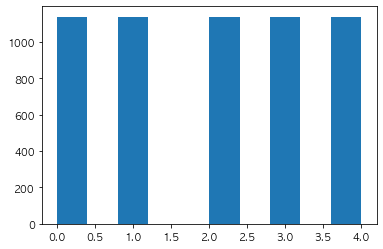

In [45]:
values = (sorted_q_d_idx.values())
print(values)
plt.hist(values)
plt.show()